### Identifying topics in recent top news articles

This notebook uses LDA modeling to identify topics in recent top news articles.  
The articles are gathered via API calls through newsapi.org and selected by popularity from each provider.  
  
The notebook is intended as a generic solution to gathering and topic modeling news. The period and category for the articles can be changed. Given the dynamic nature, the best model and analysis of the results will be in a different notebook. 
This also means that there is no guarantee of interpretability in the resulting topics, as these will most likely require tuning depending on the specific subset of news articles.  
  
Topic modeling is in my opinion only a first exploratory step that can assist subsequent analysis. The "topics" themselves should be explored in the context of the actual news content.

In [77]:
import pandas as pd
import numpy as np
import os
import requests
import json
import re
import itertools
import datetime
from tqdm.notebook import tqdm_notebook
from newsapi import NewsApiClient
import nltk
import spacy
import gensim
from gensim import models
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud

In [2]:
pd.set_option('max_colwidth', 600)

### Getting news data via API call

Getting news articles via API call through newsapi.  
Ideally I would like more data, but the API calls are (understandably) restricted in the free version.  

In [3]:
# API KEY - remember to remove!
newsapi = NewsApiClient(api_key='xxxxxxxxxxxxxxxxxxxxxxxxxxx')

In [4]:
# API call parameters
from_date = '2022-01-28'
to_date = '2022-02-27'
pages = range(1,5)

In [5]:
# Getting a list of sources in general news
def get_sources_general():
    sources_list = newsapi.get_sources(language='en',country='us',category='general')
    sources_df = pd.json_normalize(sources_list,record_path=['sources'])
    return sources_df

In [6]:
# Getting a list of sources in technology news
def get_sources_tech():
    sources_list = newsapi.get_sources(language='en',country='us',category='technology')
    sources_df = pd.json_normalize(sources_list,record_path=['sources'])
    return sources_df

In [7]:
# Getting news
def get_news(p):
    news_dict = {}
    sources = sources_df['id']
    for s in sources:
        response = newsapi.get_everything(sources=s,
                                          page=p,
                                          from_param=from_date,
                                          to=to_date,
                                          language='en',
                                          sort_by='popularity')
        flatten = pd.json_normalize(response,record_path=['articles'])
        news_dict[s] = flatten
    news_df = pd.concat([news_dict[s] for s in sources],ignore_index=True)        
    return news_df

In [8]:
def get_news_multiple_pages(pages):
    news_dict = {}
    for p in tqdm_notebook(pages):
        news_dict[p] = get_news(p)
    news_df = pd.concat([news_dict[p] for p in pages],ignore_index=True)
    return news_df

In [9]:
# Get sources
sources_df = get_sources_tech()
# Get news
news_df = get_news_multiple_pages(pages)
# Save to csv
sources_df.to_csv('sources.csv',index=False)
news_df.to_csv('news.csv',index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

### Loading data

In [10]:
# Get data
news_df = pd.read_csv('news.csv')
sources_df = pd.read_csv('sources.csv')

In [11]:
# Optionally select sources
#select_sources = ['techradar','engadget','wired']
#news_df = news_df[news_df['source.id'].isin(select_sources)]
#news_df.reset_index()

In [12]:
news_df['publishedAtDt'] = pd.to_datetime(news_df['publishedAt'])

In [13]:
news_df.head()

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name,publishedAtDt
0,Jonathan M. Gitlin,Kia’s new EV6 electric crossover goes straight to the head of the pack,"It's highly efficient, fun to drive, and loaded with equipment, too.",https://arstechnica.com/cars/2022/01/kias-new-ev6-electric-crossover-goes-straight-to-the-head-of-the-pack/,https://cdn.arstechnica.net/wp-content/uploads/2022/01/Kia-EV6-1-760x380.jpg,2022-01-31T05:01:06Z,"Enlarge/ This is Kia's distinctively styled EV6, a new electric crossover that's one of the best we've tested.\r\n6 with 6 posters participating\r\nKia provided two nights in a hotel and a flight from Sa… [+5926 chars]",ars-technica,Ars Technica,2022-01-31 05:01:06+00:00
1,Jonathan M. Gitlin,"Tesla recalls 53,822 cars because they won’t stop at stop signs","The government is not happy with the software's ""rolling stop"" function.",https://arstechnica.com/cars/2022/02/tesla-recalls-53822-cars-because-they-wont-stop-at-stop-signs/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/tesla-stop-sign-760x380.jpg,2022-02-01T16:15:38Z,"9 with 9 posters participating\r\nTesla's controversial hands-free driver-assistance system is the subject of yet another safety recall. In November, the automaker had to recall nearly 12,000 cars afte… [+1620 chars]",ars-technica,Ars Technica,2022-02-01 16:15:38+00:00
2,Ars Contributors,Surprise eruptions are Earth’s overlooked threat,We knew that volcano was prone to eruptions—but there are many we're not sure about.,https://arstechnica.com/science/2022/01/surprise-eruptions-are-earths-overlooked-threat/,https://cdn.arstechnica.net/wp-content/uploads/2022/01/343_0120-760x380.jpg,2022-01-31T20:40:37Z,"4 with 4 posters participating\r\nHunga Tonga-Hunga Ha'apai erupted on January 15 in one of the largest volcanic events in decades, and research in recent years indicates that the volcano produces simi… [+4012 chars]",ars-technica,Ars Technica,2022-01-31 20:40:37+00:00
3,Sam Machkovech,Ubisoft execs: “Gamers are always right”—yet they somehow “misunderstand” NFTs,Interview coincidentally lands on same day Ubi announces 2020 game's shutdown.,https://arstechnica.com/gaming/2022/01/ubisoft-execs-gamers-are-always-right-yet-they-somehow-misunderstand-nfts/,https://cdn.arstechnica.net/wp-content/uploads/2022/01/ubisoft-nft-headache-this-big-760x380.jpg,2022-01-29T14:00:51Z,"Enlarge/ This galaxy brain image is still working out Ubisoft's apparent ""piece-by-piece"" puzzle explanation of its NFT plans.\r\n26 with 19 posters participating\r\nIn the weeks since Ubisoft rolled out… [+3903 chars]",ars-technica,Ars Technica,2022-01-29 14:00:51+00:00
4,Jennifer Ouellette,"This Ancient Roman ceramic pot was probably a portable toilet, study finds",It's the first time parasite eggs have been found in concreted layers of a Roman pot.,https://arstechnica.com/science/2022/02/this-ancient-roman-ceramic-pot-was-probably-a-portable-toilet-study-finds/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/parasiteTOP-760x380.jpg,2022-02-11T22:19:14Z,"Enlarge/ Rim fragments of a chamber pot being excavated at a Roman villa site in Sicily.\r\n0 with 0 posters participating\r\nAncient Roman archaeological sites are littered with ceramic pots, and it can… [+3068 chars]",ars-technica,Ars Technica,2022-02-11 22:19:14+00:00


In [14]:
sources_df.head()

,id,name,description,url,category,language,country
0,ars-technica,Ars Technica,"The PC enthusiast's resource. Power users and the tools they love, without computing religion.",http://arstechnica.com,technology,en,us
1,crypto-coins-news,Crypto Coins News,"Providing breaking cryptocurrency news - focusing on Bitcoin, Ethereum, ICOs, blockchain technology, and smart contracts.",https://www.ccn.com,technology,en,us
2,engadget,Engadget,Engadget is a web magazine with obsessive daily coverage of everything new in gadgets and consumer electronics.,https://www.engadget.com,technology,en,us
3,hacker-news,Hacker News,"Hacker News is a social news website focusing on computer science and entrepreneurship. It is run by Paul Graham's investment fund and startup incubator, Y Combinator. In general, content that can be submitted is defined as ""anything that gratifies one's intellectual curiosity"".",https://news.ycombinator.com,technology,en,us
4,recode,Recode,"Get the latest independent tech news, reviews and analysis from Recode with the most informed and respected journalists in technology and media.",http://www.recode.net,technology,en,us


To get as much information as possible and given the slightly different ways of using the description field on the sources, I concatenate the title and description to use in the analysis.

In [15]:
news_df['title_desc'] = news_df['title']+' '+news_df['description']

In [16]:
# Analysis field (only using unigrams)
field = 'title_desc'
#field = 'title'

### Preprocessing

This step performs various preprocessing techniques with one primary goal - create input for the topic model with as many "meaningful" words as possible:  
- Basic text cleaning.  
- Removal of stopwords.  
- Removal of short words.  
- POS-tagging for better lemmatization and possibly filtering to give the LDA model more meaning.  
- Lemmatization and stemming (stemming should in theory be unnecessary, but I do it just to be sure).

In [17]:
# Creating list of stopwords
spacy_stopwords = spacy.load('en_core_web_sm').Defaults.stop_words
nltk_stopwords = nltk.corpus.stopwords.words('english')
stopwords_list = []
stopwords_list.extend(spacy_stopwords)
stopwords_list.extend(nltk_stopwords)

In [18]:
# Identifying the POS-tag as input for lemmatization for better result
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

**POS-tags**

| Tag  | Meaning             | Examples                               |
|------|---------------------|----------------------------------------|
| ADJ  | adjective           | new, good, high, special, big, local   |
| ADP  | adposition          | on, of, at, with, by, into, under      |
| ADV  | adverb              | really, already, still, early, now     |
| CONJ | conjunction         | and, or, but, if, while, although      |
| DET  | determiner, article | the, a, some, most, every, no, which   |
| NOUN | noun                | year, home, costs, time, Africa        |
| NUM  | numeral             | twenty-four, fourth, 1991, 14:24       |
| PRT  | particle            | at, on, out, over per, that, up, with  |
| PRON | pronoun             | he, their, her, its, my, I, us         |
| VERB | verb                | is, say, told, given, playing, would   |
| .    | punctuation marks   | . , ; !                                |
| X    | other               | ersatz, esprit, dunno, gr8, univeristy |

In [19]:
# Allowed POS-tags
#allowed_pos = ['n','v','r]
allowed_pos = ['n','v']

In [20]:
# Preprocessing
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    # Lowercase
    sentence = sentence.lower()
    
    # Removing special characters and numbers
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_char = re.sub('[^A-Za-z ]+', '', rem_url)
    rem_num = re.sub('[0-9]+', '', rem_char)
    
    # Tokenization
    tokens = tokenizer.tokenize(rem_num) 
    
    # Remove stopwords and short words
    filtered_words = [w for w in tokens if len(w) > 3 if not w in stopwords_list if get_wordnet_pos(w) in (allowed_pos)]
    #filtered_words = [w for w in tokens if len(w) > 3 if not w in stopwords_list]
    
    # Stemming
    stem_words=[stemmer.stem(w) for w in filtered_words]
    
    # Lemmatizer
    lemma_words=[lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in stem_words]
    
    return " ".join(filtered_words)

In [21]:
news_df['lemma']=news_df[field].apply(preprocess) 

In [22]:
news_df.head()

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name,publishedAtDt,title_desc,lemma
0,Jonathan M. Gitlin,Kia’s new EV6 electric crossover goes straight to the head of the pack,"It's highly efficient, fun to drive, and loaded with equipment, too.",https://arstechnica.com/cars/2022/01/kias-new-ev6-electric-crossover-goes-straight-to-the-head-of-the-pack/,https://cdn.arstechnica.net/wp-content/uploads/2022/01/Kia-EV6-1-760x380.jpg,2022-01-31T05:01:06Z,"Enlarge/ This is Kia's distinctively styled EV6, a new electric crossover that's one of the best we've tested.\r\n6 with 6 posters participating\r\nKia provided two nights in a hotel and a flight from Sa… [+5926 chars]",ars-technica,Ars Technica,2022-01-31 05:01:06+00:00,"Kia’s new EV6 electric crossover goes straight to the head of the pack It's highly efficient, fun to drive, and loaded with equipment, too.",kias crossover goes straight head pack efficient drive loaded equipment
1,Jonathan M. Gitlin,"Tesla recalls 53,822 cars because they won’t stop at stop signs","The government is not happy with the software's ""rolling stop"" function.",https://arstechnica.com/cars/2022/02/tesla-recalls-53822-cars-because-they-wont-stop-at-stop-signs/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/tesla-stop-sign-760x380.jpg,2022-02-01T16:15:38Z,"9 with 9 posters participating\r\nTesla's controversial hands-free driver-assistance system is the subject of yet another safety recall. In November, the automaker had to recall nearly 12,000 cars afte… [+1620 chars]",ars-technica,Ars Technica,2022-02-01 16:15:38+00:00,"Tesla recalls 53,822 cars because they won’t stop at stop signs The government is not happy with the software's ""rolling stop"" function.",tesla recalls cars wont stop stop signs government softwares rolling stop function
2,Ars Contributors,Surprise eruptions are Earth’s overlooked threat,We knew that volcano was prone to eruptions—but there are many we're not sure about.,https://arstechnica.com/science/2022/01/surprise-eruptions-are-earths-overlooked-threat/,https://cdn.arstechnica.net/wp-content/uploads/2022/01/343_0120-760x380.jpg,2022-01-31T20:40:37Z,"4 with 4 posters participating\r\nHunga Tonga-Hunga Ha'apai erupted on January 15 in one of the largest volcanic events in decades, and research in recent years indicates that the volcano produces simi… [+4012 chars]",ars-technica,Ars Technica,2022-01-31 20:40:37+00:00,Surprise eruptions are Earth’s overlooked threat We knew that volcano was prone to eruptions—but there are many we're not sure about.,surprise eruptions earths overlooked threat knew volcano prone eruptionsbut sure
3,Sam Machkovech,Ubisoft execs: “Gamers are always right”—yet they somehow “misunderstand” NFTs,Interview coincidentally lands on same day Ubi announces 2020 game's shutdown.,https://arstechnica.com/gaming/2022/01/ubisoft-execs-gamers-are-always-right-yet-they-somehow-misunderstand-nfts/,https://cdn.arstechnica.net/wp-content/uploads/2022/01/ubisoft-nft-headache-this-big-760x380.jpg,2022-01-29T14:00:51Z,"Enlarge/ This galaxy brain image is still working out Ubisoft's apparent ""piece-by-piece"" puzzle explanation of its NFT plans.\r\n26 with 19 posters participating\r\nIn the weeks since Ubisoft rolled out… [+3903 chars]",ars-technica,Ars Technica,2022-01-29 14:00:51+00:00,Ubisoft execs: “Gamers are always right”—yet they somehow “misunderstand” NFTs Interview coincidentally lands on same day Ubi announces 2020 game's shutdown.,execs gamers rightyet misunderstand nfts interview lands announces games shutdown
4,Jennifer Ouellette,"This Ancient Roman ceramic pot was probably a portable toilet, study finds",It's the first time parasite eggs have been found in concreted layers of a Roman pot.,https://arstechnica.com/science/2022/02/this-ancient-roman-ceramic-pot-was-probably-a-portable-toilet-study-finds/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/parasiteTOP-760x380.jpg,2022-02-11T22:19:14Z,"Enlarge/ Rim fragmen

### Create corpus

In [23]:
# List of articles
data_words = []

for _, row in news_df.iterrows():
    data_words.append(row['lemma'].split(' '))

# Create dictionary
id2word = corpora.Dictionary(data_words)

# no_below: Filter words that appear in "no_below" number of articles.
# no_above: Filter words that appear in more than "no_above" % articles.
id2word.filter_extremes(no_below=10, no_above=0.35)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text,allow_update=True) for text in data_words]

### LDA model training

The LDA (Latent Dirichlet Allocation) is a probabilistic model that generates a predetermined number of topics based on patterns of words that appear together in the articles. The topics are represented by a word distribution and the articles are mapped to each topic with a probability.  The result can be seen as two lists:  
- A list of topics represented by words and the corresponding probability that the word belongs to that topic. 
- A list of news articles and the corresponding probability that the article belongs to a topic.  
  
This is a nuanced view, where words and articles can belong to multiple topics.

In [24]:
# Gensim LDA model

# Comments on parameters
# A lower alpha means documents will be composed of fewer dominant topics.
# A lower beta means fewer dominant words per topic.
# Lower values will then make the topics more distinct at the cost of missing the big picture.

def train_model(notopics):
    
    chunksize = 1000
    passes = 250
    iterations = 400
    eval_every = None
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            chunksize=chunksize,
                                            alpha=0.5,
                                            eta=0.01,
                                            #alpha=0.5,
                                            #eta=0.01,
                                            #alpha='auto',
                                            #eta='auto',
                                            iterations=iterations,
                                            num_topics=notopics,
                                            passes=passes,
                                            eval_every=eval_every,
                                            per_word_topics=True)    
    return model

In [25]:
# Grid search
grid_params = range(15,26)
lda_model_list = []
for n in tqdm_notebook(grid_params):
    lda_model = train_model(n)
    lda_model_list.append(lda_model)

  0%|          | 0/11 [00:00<?, ?it/s]

In [26]:
# Coherence score
def calc_coherence(coherence):
    coherence_values = []

    for i in tqdm_notebook(range(len(grid_params))):
        cm = CoherenceModel(model=lda_model_list[i], texts=texts, coherence=coherence)
        coherence_values.append(cm.get_coherence())
    return coherence_values

  0%|          | 0/11 [00:00<?, ?it/s]

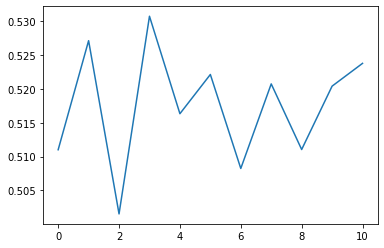

In [27]:
coherence_values = calc_coherence('c_v')
sns.lineplot(data=coherence_values)
plt.show()

In [28]:
# Pick optimal model

# Highest score
opt_ind = np.argmax(coherence_values)

# Manual pick
#opt_ind = 10

optimal_model = lda_model_list[opt_ind]
model_topics = optimal_model.show_topics(formatted=False)
numtopics = optimal_model.num_topics
print('No of topics:',numtopics,' Best score:',max(coherence_values),' No in list:',opt_ind)

No of topics: 18  Best score: 0.5307140748896327  No in list: 3


In [30]:
# Load model
#optimal_model.load('Saved_models/lda_model')

### Visualize the topics

Basically, the bubbles should be as large as possible and not overlap. That means the topics are distinct and catch general patterns.

In [31]:
%%capture --no-display
pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.189579  0.108561       1        1  6.476578
15    -0.073583  0.091863       2        1  6.284373
2     -0.101932 -0.133045       3        1  6.242306
10    -0.006403 -0.125131       4        1  6.134778
6     -0.140491  0.024643       5        1  6.059626
12     0.110357 -0.042954       6        1  6.055210
4     -0.158623 -0.033228       7        1  5.933843
1      0.062081 -0.079998       8        1  5.755670
9     -0.061031  0.110678       9        1  5.705741
16     0.077480 -0.201034      10        1  5.672166
0     -0.049919 -0.012679      11        1  5.669813
14    -0.059358 -0.004115      12        1  5.329924
7     -0.003799 -0.019162      13        1  5.084930
8      0.099438 -0.156189      14        1  5.069955
11     0.051059  0.177533      15        1  4.987864
3      0.077374  0.050898      16        1  4.785096
17     0.174757  0.113788      17        1  4.621004
13     0.192171  0.129570      18        1  4.131125, topic_info=           Term       Freq      Total Category  logprob  loglift
39        apple  34.000000  34.000000  Default  30.0000  30.0000
13      company  52.000000  52.000000  Default  29.0000  29.0000
7          data  21.000000  21.000000  Default  28.0000  28.0000
91       galaxy  25.000000  25.000000  Default  27.0000  27.0000
40    microsoft  26.000000  26.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
5          time   4.992579  42.508943  Topic18  -4.5323   1.0449
10      trailer   2.700644  14.422731  Topic18  -5.1468   1.5113
1330       devs   2.200279   3.235879  Topic18  -5.3517   2.8009
2544   computer   2.291162   6.118218  Topic18  -5.3112   2.2044
1617       rise   2.214298   7.306008  Topic18  -5.3453   1.9929

[1026 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
76       16  1.012477           
3581      3  0.992950  abandoned
2495      8  0.976551  accepting
368       3  0.105804     access
368       5  0.317413     access
...     ...       ...        ...
1194      4  0.635888      youve
1194      8  0.211963      youve
1194     11  0.211963      youve
2645      9  1.013385       zagg
2447      6  1.035769       zeus

[1620 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 16, 3, 11, 7, 13, 5, 2, 10, 17, 1, 15, 8, 9, 12, 4, 18, 14])

### Add model to original data

In [32]:
def format_topics(ldamodel, corpus, texts):
    # Init output
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    
    return(topics_df)

In [33]:
doc_dominant_df = format_topics(ldamodel=optimal_model, corpus=corpus, texts=news_df['title'])

In [34]:
# Representative Text

topics_sorted = pd.DataFrame()
topics_out_grpd = doc_dominant_df.groupby('Dominant_Topic')

for i, grp in topics_out_grpd:
    topics_sorted = pd.concat([topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Format
topics_sorted.columns = ["Repr_Dominant_Topic", "Repr_Perc_Contribution", "Repr_Topic_Keywords", "Representative_Text"]

In [35]:
# Join everything
news_analysis_df = pd.concat([news_df,doc_dominant_df],axis='columns')
news_analysis_df = pd.merge(news_analysis_df,topics_sorted,how="inner",left_on='Dominant_Topic',right_on='Repr_Dominant_Topic',sort=True,copy=True)

In [36]:
# Export to csv
news_analysis_df.to_csv('news_analysis.csv',index=False)

### Initial results

**Topics and top words**

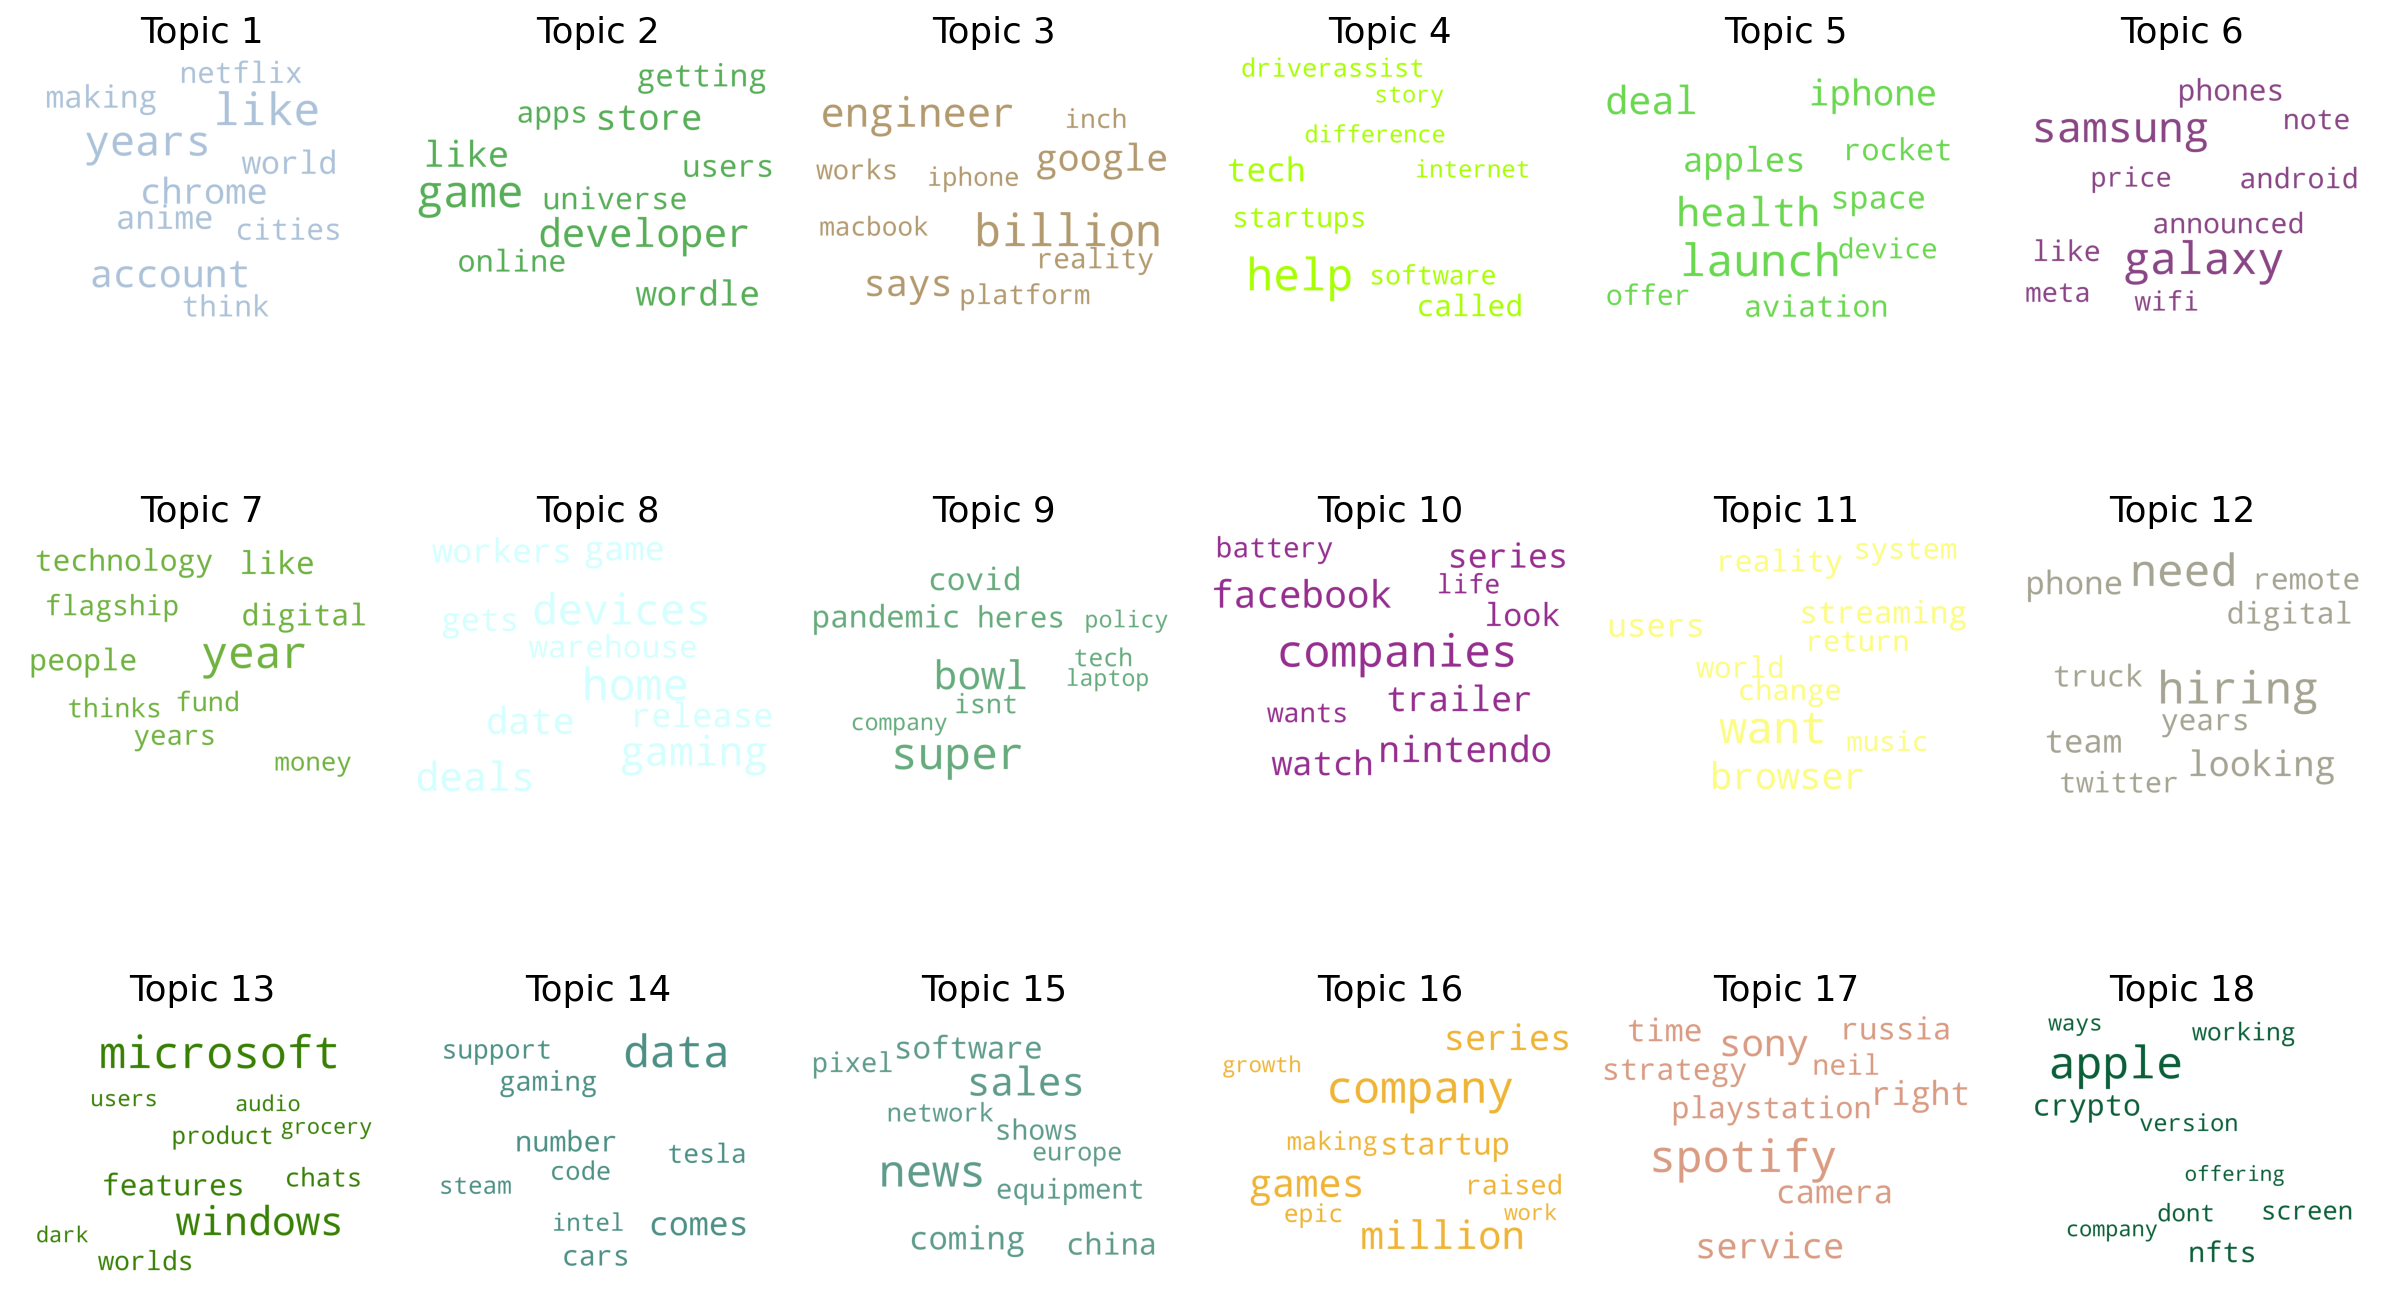

In [46]:
# Wordcloud

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(num_topics=numtopics, formatted=False, num_words=10)

fig, axes = plt.subplots(3, 6, figsize=(15,10), sharex=True, sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    if i >= numtopics:
        break
    else:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i+1) + '', fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Top-10 words in each topic based on the percentage contribution of the word in the topic

**Topics ranked by coherence**

In [47]:
topic_top_coherence = optimal_model.top_topics(corpus=corpus, texts=texts, dictionary=id2word, window_size=None, coherence='c_v', topn=5, processes=- 1)

In [48]:
pd.DataFrame.from_dict(topic_top_coherence)

,0,1
0,"[(0.034195356, galaxy), (0.030532848, samsung), (0.01222012, phones), (0.011392401, like), (0.011124405, android)]",0.567597
1,"[(0.040993482, company), (0.030856093, million), (0.030227926, games), (0.025028452, series), (0.018765781, startup)]",0.490426
2,"[(0.03010227, hiring), (0.029662982, need), (0.017375343, looking), (0.014711406, phone), (0.014564597, team)]",0.484966
3,"[(0.023038143, companies), (0.015961625, facebook), (0.014517986, nintendo), (0.013613515, trailer), (0.012765788, watch)]",0.482985
4,"[(0.0370778, help), (0.021744274, ), (0.018692933, tech), (0.015008744, called), (0.013301924, startups)]",0.446908
5,"[(0.020971067, home), (0.019123478, devices), (0.017699793, gaming), (0.016754892, deals), (0.0144388145, date)]",0.408130
6,"[(0.019512685, launch), (0.015304525, health), (0.014333831, deal), (0.012093437, iphone), (0.010984742, apples)]",0.403848
7,"[(0.03237055, microsoft), (0.025384385, windows), (0.012594508, features), (0.009862485, worlds), (0.009359469, chats)]",0.391701
8,"[(0.028249519, year), (0.011675882, like), (0.010552267, people), (0.010543043, digital), (0.010349613, technology)]",0.364330
9,"[(0.022830574, game), (0.017429456, developer), (0.014093736, store), (0.014066079, like), (0.013076072, wordle)]",0.342948


**Topics ranked by number of articles**

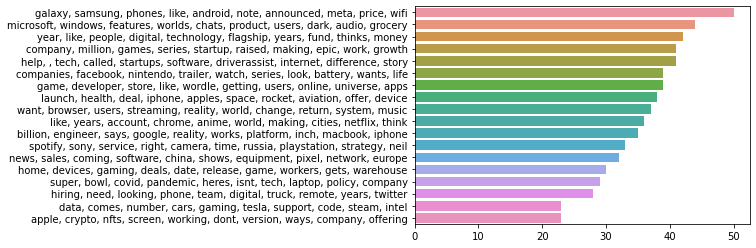

In [49]:
sns.barplot(x=news_analysis_df['Topic_Keywords'].value_counts().values,y=news_analysis_df['Topic_Keywords'].value_counts().index)
plt.show()

**Topics and most representative article**

In [50]:
topics_sorted[['Repr_Topic_Keywords','Representative_Text']]

,Repr_Topic_Keywords,Representative_Text
586,"like, years, account, chrome, anime, world, making, cities, netflix, think",Newly discovered Mars zircon may hold the secret to life on the red planet
275,"game, developer, store, like, wordle, getting, users, online, universe, apps",Twitter’s accepting tips in Ethereum — and Dorsey must be fuming
348,"billion, engineer, says, google, reality, works, platform, inch, macbook, iphone",Biden administration forms Buy Clean Task Force to decarbonize federal procurement
128,"help, , tech, called, startups, software, driverassist, internet, difference, story",Russian fans of The Sims can’t play My Wedding Stories expansion pack because of anti-gay law
101,"launch, health, deal, iphone, apples, space, rocket, aviation, offer, device",SpaceX’s derelict rocket will crash and create a worrying new Moon crater
80,"galaxy, samsung, phones, like, android, note, announced, meta, price, wifi",Redmi Note 11 Pro and Note 11 Pro Plus to launch in India on March 9 - Techradar
109,"year, like, people, digital, technology, flagship, years, fund, thinks, money",The auto sector thinks Tesla’s full of shit with its ‘full self-driving’
282,"home, devices, gaming, deals, date, release, game, workers, gets, warehouse",Amazon workers at Staten Island warehouse will vote next month on whether to unionize
196,"super, bowl, covid, pandemic, heres, isnt, tech, laptop, policy, company",'Wall Street Journal' and its owners hit by cyberattack linked to China
193,"companies, facebook, nintendo, trailer, watch, series, look, battery, wants, life",Jabra's hearing enhancement earbuds will be available this month for $799


In [75]:
def save_good_model(yn):
    filedate = 'saved_set_'+datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    os.mkdir('news\{}'.format(filedate))
    if yn == True:
        optimal_model.save('news\{}\lda_model'.format(filedate))
        sources_df.to_csv('news\{}\sources.csv'.format(filedate),index=False)
        news_df.to_csv('news\{}\news.csv'.format(filedate),index=False)
        news_analysis_df.to_csv('news\{}\news_analysis.csv'.format(filedate),index=False)
        print('Saved')
    else:
        print('Not saved')        

In [76]:
# Save model
save_good_model(True)

Saved
